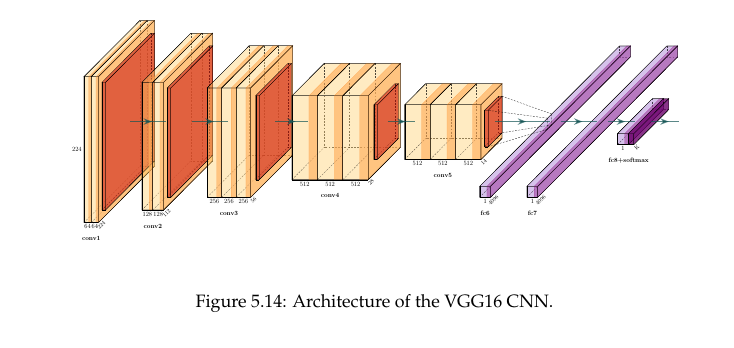

VGG= Visual Geometry Group: Oxford University. Gano el primer y segundo lugar en ImageNet challenge 2014. Con 92.7% top accuracy.

* Los autores tiene su publicacion. : Karen Simonyan y Andrew Zisserman (2015).

* Todas las convoluciones son de  3×3  (kernels). Stride  s=1  y padding "same" (preserva el tamano entre la entrada y la salida). Todos los pooling son MaxPooling con tamanos  2×2  y stride  s=2 .

* Hagamos la descripcion aca y la implemantacion en la proxima clase.

* Todas las activaciones son ReLU (excepto por la ultima que es softmax). Se aplican luego de cada convolucion.

* A partir de este momento no contamos parametros ni encontramos dimensiones.

* Capa de entrada y primera convolucion: Salida de convolucion 64 filtros, la entrada es  224×224×3 . A esto le sigue un MaxPooling.

* Segunda capa convolucional: Filtros de salida 128 , seguida por MaxPooling.

* Tercera capa: Tres convoluciones cada una con 256 filtros, sesguida de MaxPooling

* Cuarta capa: Tres convoluciones con 512 filtros de salida, seguida por MaxPooling.

* Quinta capa convolucional: Tres convoluciones tambien con 512, seguida de MaxPooling.

* Flattening: Se vectorizan en una "tira" de 4096 componentes.

* Fully connected (densa). Se conectan las 4096 componentes (neuronas) con otras 4096 componentes.

* Fully connected con una funcion de activacion softmax. En el concurso se hace con 1000 salidas. Nosotros usamos 17 (las flores).

In [26]:
# VGG16
# importar librerias
import tensorflow as tf
tf.__version__

'2.8.0'

In [27]:
import keras
keras.__version__

'2.8.0'

In [28]:
# importar mas librerias
!pip install tflearn

from tflearn.datasets import oxflower17
from keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical # realmente no la vamos a necesitar
from keras.layers import Conv2D, Dropout, MaxPooling2D, Input
from keras.layers import BatchNormalization, Activation, Flatten, Dense




In [29]:
# cargar datos
# load data
# X, Y = oxflower17.load_data(r'Data/jpg')
X,Y = oxflower17.load_data(one_hot=True)


In [30]:
# dimensiones en los datos
X.shape, Y.shape

((1360, 224, 224, 3), (1360, 17))

In [31]:
Y[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
# definamos un VGG block
def vgg_block(layer_in, n_filters, n_conv):
    for _ in range(n_conv):
        # convolucion
        layer_in  = Conv2D( n_filters, (3,3), padding='same',
                           activation='relu')(layer_in)

    # maxpooling
    layer_in = MaxPooling2D( (2,2), strides=(2,2))(layer_in)

    return layer_in

#### Definicion del *modelo*

In [33]:
model = Sequential()

# primera convolucion
input_layer = Input( shape=(224,224,3))
# agregamos una conv-vgg
layer=vgg_block(input_layer, 64, 2)

# segundo grupo de convoluciones
layer= vgg_block(layer, 128, 2)

# tercer grupo de convoluciones
layer = vgg_block( layer, 256, 3)

# cuarto grupo 
layer = vgg_block(layer, 512, 3)

# quinto y ultimo grupo
layer = vgg_block(layer, 512, 3)

# primera capa densa
layer=Flatten()(layer)
layer=Dense(4096)(layer)

# Dropout
layer = (Dropout(0.5))(layer)
layer = (Activation('relu'))(layer)


# segunda capa densa
layer = Dense(4096)(layer)


# Dropout
layer=(Dropout(0.5))(layer)

# Normalizacion
layer=(BatchNormalization())(layer)
layer=(Activation('relu'))(layer)

# salida con un softmax
layer=(Dense(17))(layer)
layer=(Activation('softmax'))(layer)

model = Model(inputs=input_layer, outputs=layer)
model.summary()





Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 128)     

#### Compilar Modelo

In [35]:
from keras.backend import learning_phase
model.compile(optimizer=tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name='RMSprop'
)
, loss='categorical_crossentropy', metrics=['accuracy'])

#### Entrenamiento

In [36]:
model.fit(X, Y, batch_size=32, epochs=30, verbose=1, validation_split=0.2, shuffle=True)

Train on 1088 samples, validate on 272 samples
Epoch 1/30
1088/1088 [==============================] - ETA: 0s - loss: 3.4709 - acc: 0.0938

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1088/1088 [==============================] - 68s 63ms/sample - loss: 3.4709 - acc: 0.0938 - val_loss: 2.9672 - val_acc: 0.0956
Epoch 2/30
1088/1088 [==============================] - 44s 40ms/sample - loss: 3.0049 - acc: 0.1222 - val_loss: 9.6321 - val_acc: 0.1066
Epoch 3/30
1088/1088 [==============================] - 44s 40ms/sample - loss: 2.8948 - acc: 0.1461 - val_loss: 2.7889 - val_acc: 0.2169
Epoch 4/30
1088/1088 [==============================] - 44s 40ms/sample - loss: 2.6985 - acc: 0.2233 - val_loss: 2.7039 - val_acc: 0.1949
Epoch 5/30
1088/1088 [==============================] - 44s 40ms/sample - loss: 2.4298 - acc: 0.2390 - val_loss: 13.5239 - val_acc: 0.0662
Epoch 6/30
1088/1088 [==============================] - 44s 40ms/sample - loss: 2.4463 - acc: 0.2877 - val_loss: 3.6172 - val_acc: 0.2316
Epoch 7/30
1088/1088 [==============================] - 44s 40ms/sample - loss: 2.3672 - acc: 0.2914 - val_loss: 2.9182 - val_acc: 0.2868
Epoch 8/30
1088/1088 [======================

# GoogLeNet (no es google net, Goog, Le Net.
* Se publico en 2015 por Szegedy et. al., de Google Inc.
* Es la primera red no secuencial (famosa). Hasta este momento las redes profundas eran un pila de capas en orden secuencial. Se queria innovar con redes no secuenciales.
* Tambien ls GoogLeNet (tambien tiene otro nombre Inception) tiene bloques de convoluciones con activaciones. A estos bloques se les llama **inception bloques**
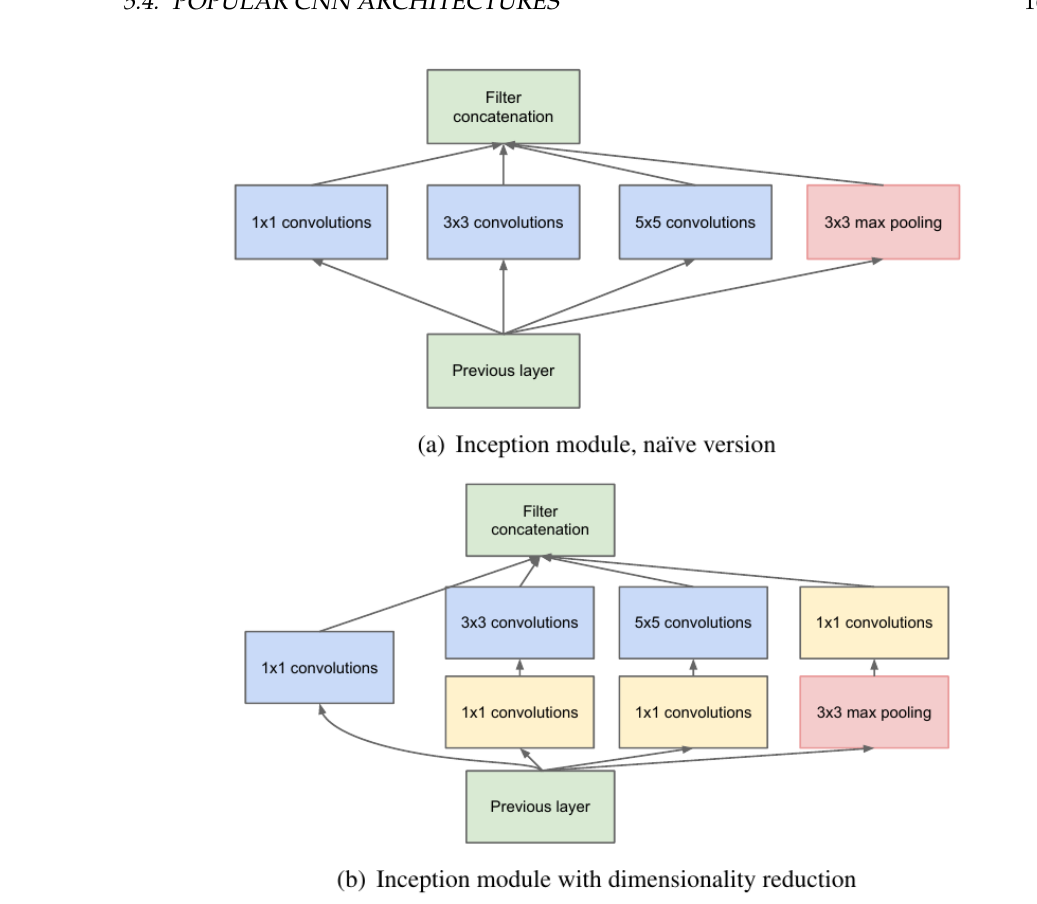

Que es una convolucion $1 \times 1$ y para que sirve?

Segun Brownlee. Los primeros filtros $1 \times 1$ fueron introducidos en 2013 por Min Lin bajo el titulo Network In Network . 

Una idea fundamental para la convolucion $1 \times 1$ es la  reduccion de parametros como lo explicamos enseguida.  Otra idea que funciona en la convolucion $1 \times 1$ es la flexibilidad para cambiar filtros de salida. Esto lo vemos cuando implementos el algoritmo. 

La convolucion $1 \times 1$ es como un sum-pooling (stack) a lo largo de la dimensionn de los filtros. Por que?.
Cada celda de los datos de entrada se va a multiplicar por el filtro $1 \times 1$. El filtro tiene esta forma $f_{ijk}$. La salida

$$\textrm{out}_{ij} = \sum_{l =1}^{k} f_{ijk} \text{in}_{ijl} $$
$i=1,2, \cdots, \text{ancho}$, $j=1,2, \cdots,  \text{alto}$ y
$l=1,2, \cdots, k$. 

Podemos extender esto para sacar un numero de filtros de salida.

$$\textrm{out}_{ij}^p = \sum_{l =1}^{k} f_{ijk}^p \text{in}_{ijl} $$
$ p = 1,2, \cdots, n_f$.

Miremos como la convolucion $1 \times 1$ reduce el numero de parametros.

$$ \# \text{parametros} = (1 \times 1 \times \text{depth} +1) \times  nf $$

Si en vez de $1 \times 1$ fuese $5 \times 5$ la ganancia es de 25 a 1. 

Veamos un ejemplo mas especifico.
Asuma las imagenes del flowers-17. Estas tienen dimensiones 
$ 224 \times 224 \times 3$. Si quisieramos usar filtro (convolucion) de $5 \times 5$ con "padding same" y 256 filtros necesitamos

$$ 5 \times 5 \times 224 \times 224 \times 3 \times 256 = 963379200 $$
multiplicaciones

Si en vez de este esquema utilizamos otro esquema. 

$$ 1 \times 1 \times 224 \times 224 \times 3 \times 1 + 5 \times 5 \times 224 \times 224 \times 1 \times 256 = 321276928 $$

Antes escribir algoritmos para el GoogLeNet veamos otros puntos interesantes:

* La primera arquitectura de este estilo fue la **Inception v1** 
* Luego vino **Inception v2** y en el mismo articulo la **Inception v3**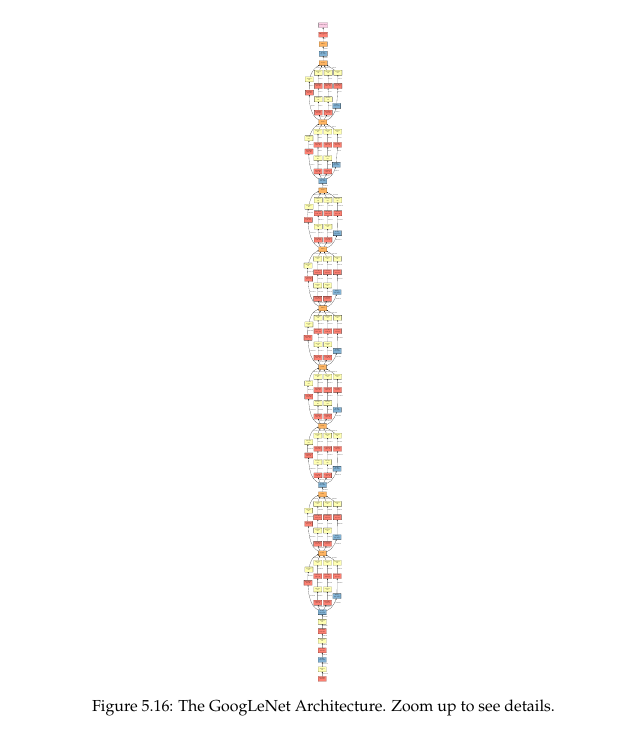
* Luego lego la **Invecption v4** y la ResNnet (enseguida la discutimos).
* Finalmente la Xception , donde "X" extreme. Introduda for Francois Chollet . 
* ver mas detalles en
[Josepth P. Cohen](https://josephpcohen.com/w/visualizing-cnn-architectures-side-by-side-with-mxnet/)



El siguiente link es usado para la implementacion

[Jason Brownlee](https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/)

In [38]:
# implementacion de un bloque del incpetion
# usando Keras API (Application programming interface)
# tomado de Machine Learning Mastery. 

def inception_module( layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1 x 1 convolucion
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)

    # 5x5 conv
    conv5 = Conv2d(f3_in, (5,5), padding='same', activation='relu')(layer_in)

    # max pooling
    pool = MaxPooling2D( (3, 3), strides=(1,1), padding='same')(layer_in)

    # concatenacion
    layer_out = concatenate( [conv1, conv3, conv5, pool], axis=1)
    return layer_out

In [ ]:
# bloque 2
def inception_module( layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # primer nivel
    # 1 x 1 convolucion
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

    # 1 x 1 convolucion
    conv12 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

    # 1 x 1 convolucion
    conv13 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

    # max pooling
    pool = MaxPooling2D( (3, 3), strides=(1,1), padding='same')(layer_in)

    # segundo nivel

    # 3x3 conv
    conv3 = Conv2D(f2_in, (3,3), padding='same', activation='relu')(conv1)

    # 5x5 conv
    conv5 = Conv2d(f3_in, (5,5), padding='same', activation='relu')(conv12)

    conv121 = Conv2D(f1, (1,1), padding='same', activation='relu')(pool)


    # concatenacion
    layer_out = concatenate( [conv1, conv3, conv5, conv121], axis=1)
    return layer_out

# ResNet : Residual Net.

* Es de Microsoft. Los autores son He et. al.
* Esta gano el ImageNnet ILSVRC del 2015. 

Cual es la idea de "residual".

Asuma un stack the capas, el residual de la salida del stack
$\mathcal{H}$ y la entrada $x$ es $\mathcal{F} = \mathcal{H} -x $
Entonces la salida $\mathcal{H}$ se puede escribir como $\mathcal{H}=x + \mathcal{F}$. 

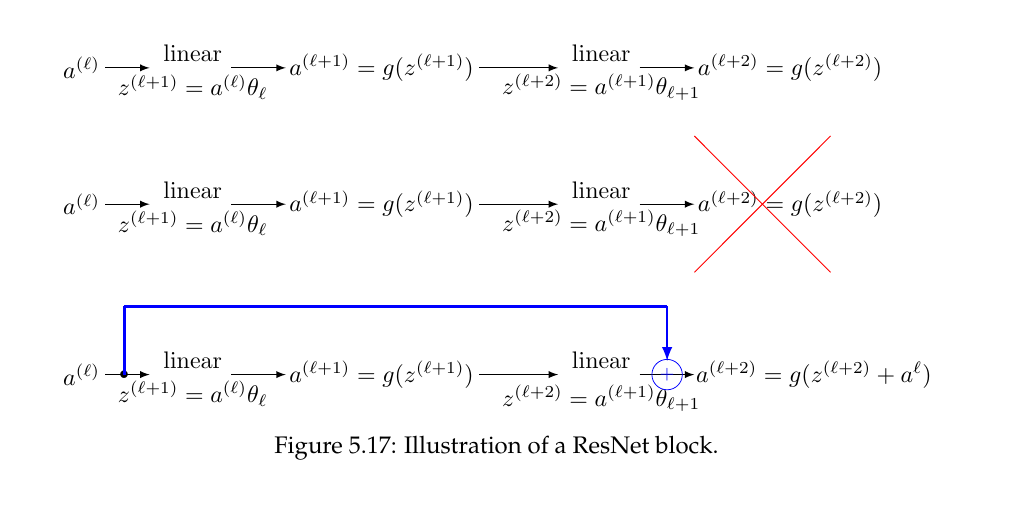

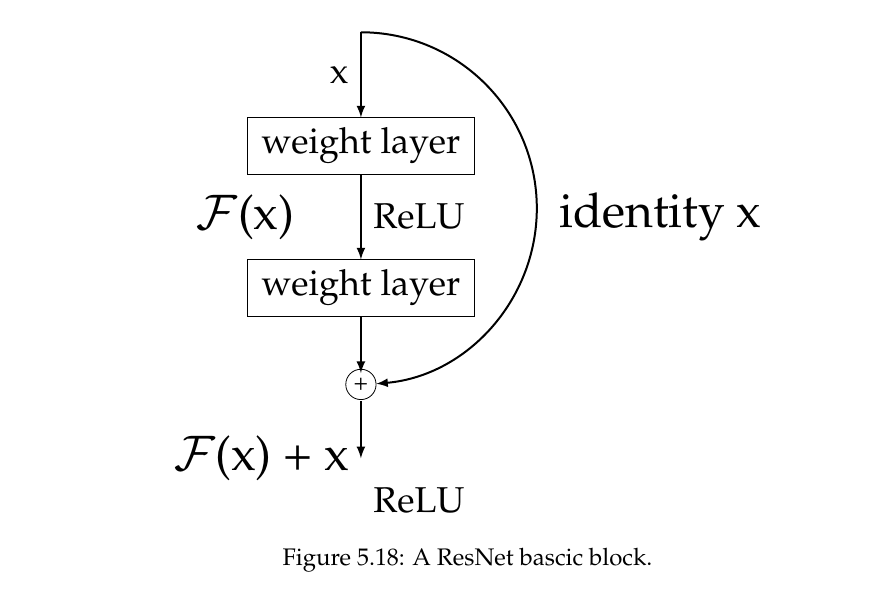